In [1]:
# env: zanalitycs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
from glob2 import glob
import matplotlib.pyplot as plt

## Simulating data

In [2]:
# Parameters
num_users = 10000
states = ['greeting', 'product_inquiry', 'purchase_decision', 'confirm_purchase', 'terminal']
actions = ['ask_preferences', 'recommend_product', 'show_discounts', 'confirm_purchase']

In [3]:
# Probabilities for transitions
state_transitions = {
    'greeting': {'product_inquiry': 0.8, 'terminal': 0.2},
    'product_inquiry': {'purchase_decision': 0.7, 'terminal': 0.3},
    'purchase_decision': {'confirm_purchase': 0.6, 'terminal': 0.4},
    'confirm_purchase': {'terminal': 1.0},
}

In [4]:
# Probabilities for actions per state
action_choices = {
    'greeting': ['ask_preferences', 'show_discounts'],
    'product_inquiry': ['recommend_product'],
    'purchase_decision': ['confirm_purchase'],
    'confirm_purchase': ['confirm_purchase'],
}

In [5]:
# Simulate sessions
data = []

for session_id in range(1, num_users + 1):
    state = 'greeting'
    timestamp = datetime(2024, 12, 5, 9, 0, 0) + timedelta(minutes=np.random.randint(0, 1440))  # Random start time
    converted = 0

    while state != 'terminal':
        action = np.random.choice(action_choices[state])  # Choose an action for the state
        next_states = list(state_transitions[state].keys())
        next_state_probs = list(state_transitions[state].values())
        next_state = np.random.choice(next_states, p=next_state_probs)  # Choose next state

        # Time lapse for transition
        time_lapse = np.random.randint(5, 30)
        timestamp += timedelta(seconds=time_lapse)

        # Determine conversion at 'confirm_purchase' state
        if state == 'confirm_purchase' and next_state == 'terminal':
            converted = np.random.choice([0, 1], p=[0.5, 0.5])  # 50% chance of purchase

        # Append the row
        data.append({
            'session_id': session_id,
            'timestamp': timestamp,
            'state': state,
            'action': action,
            'next_state': next_state,
            'time_lapse': time_lapse,
            'converted': converted
        })

        state = next_state  # Update to the next state

In [6]:
# Create the DataFrame
df = pd.DataFrame(data)

# Ensure 'converted' is consistent within a session
df['converted'] = df.groupby('session_id')['converted'].transform('max')

display(df.head(10))

,session_id,timestamp,state,action,next_state,time_lapse,converted
0,1,2024-12-05 19:55:09,greeting,ask_preferences,terminal,9,0
1,2,2024-12-05 10:16:26,greeting,ask_preferences,product_inquiry,26,0
2,2,2024-12-05 10:16:36,product_inquiry,recommend_product,purchase_decision,10,0
3,2,2024-12-05 10:16:53,purchase_decision,confirm_purchase,terminal,17,0
4,3,2024-12-05 15:25:16,greeting,ask_preferences,product_inquiry,16,0
5,3,2024-12-05 15:25:32,product_inquiry,recommend_product,terminal,16,0
6,4,2024-12-05 22:26:29,greeting,ask_preferences,product_inquiry,29,1
7,4,2024-12-05 22:26:41,product_inquiry,recommend_product,purchase_decision,12,1
8,4,2024-12-05 22:26:59,purchase_decision,confirm_purchase,confirm_purchase,18,1
9,4,2024-12-05 22:27:15,confirm_purchase,confirm_purchase,terminal,16,1


In [7]:
# Sort by session_id and timestamp to ensure proper sequence
df = df.sort_values(by=['session_id', 'timestamp'])

# Add the next_state column
df['next_state'] = df.groupby('session_id')['state'].shift(-1)

# Fill NaN next_state for the last step in each session
df['next_state'] = df['next_state'].fillna('terminal')

# Add reward column (1 for purchase at the end of session, 0 otherwise)
df['reward'] = df.groupby('session_id')['converted'].transform('max')


In [8]:
df.head(10)

,session_id,timestamp,state,action,next_state,time_lapse,converted,reward
0,1,2024-12-05 19:55:09,greeting,ask_preferences,terminal,9,0,0
1,2,2024-12-05 10:16:26,greeting,ask_preferences,product_inquiry,26,0,0
2,2,2024-12-05 10:16:36,product_inquiry,recommend_product,purchase_decision,10,0,0
3,2,2024-12-05 10:16:53,purchase_decision,confirm_purchase,terminal,17,0,0
4,3,2024-12-05 15:25:16,greeting,ask_preferences,product_inquiry,16,0,0
5,3,2024-12-05 15:25:32,product_inquiry,recommend_product,terminal,16,0,0
6,4,2024-12-05 22:26:29,greeting,ask_preferences,product_inquiry,29,1,1
7,4,2024-12-05 22:26:41,product_inquiry,recommend_product,purchase_decision,12,1,1
8,4,2024-12-05 22:26:59,purchase_decision,confirm_purchase,confirm_purchase,18,1,1
9,4,2024-12-05 22:27:15,confirm_purchase,confirm_purchase,terminal,16,1,1


In [9]:
df['session_id'].nunique()

10000

In [10]:
df.size

215128

In [11]:
if 'simmulated_data.csv' in glob('*.csv'):
    print("File exists")
else:
    print("Saving file")
    df.to_csv('simmulated_data.csv', index=False)

File exists


## Preparing dataframe

In [12]:
df = pd.read_csv('simmulated_data.csv')
df.head()

,session_id,timestamp,state,action,next_state,time_lapse,converted,reward
0,1,2024-12-05 13:03:15,greeting,ask_preferences,product_inquiry,15,0,0
1,1,2024-12-05 13:03:28,product_inquiry,recommend_product,terminal,13,0,0
2,2,2024-12-05 18:05:25,greeting,show_discounts,product_inquiry,25,1,1
3,2,2024-12-05 18:05:39,product_inquiry,recommend_product,purchase_decision,14,1,1
4,2,2024-12-05 18:05:48,purchase_decision,confirm_purchase,confirm_purchase,9,1,1


## Starting deep q-learning

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

In [14]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [15]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
df.head()

,session_id,timestamp,state,action,next_state,time_lapse,converted,reward
0,1,2024-12-05 13:03:15,greeting,ask_preferences,product_inquiry,15,0,0
1,1,2024-12-05 13:03:28,product_inquiry,recommend_product,terminal,13,0,0
2,2,2024-12-05 18:05:25,greeting,show_discounts,product_inquiry,25,1,1
3,2,2024-12-05 18:05:39,product_inquiry,recommend_product,purchase_decision,14,1,1
4,2,2024-12-05 18:05:48,purchase_decision,confirm_purchase,confirm_purchase,9,1,1


In [18]:
# Include all states and next states in the label encoding
all_states = pd.concat([df['state'], df['next_state']]).unique()
le_state = LabelEncoder()
le_state.fit(all_states)

# Encode state and next_state
df['state'] = le_state.transform(df['state'])
df['next_state'] = le_state.transform(df['next_state'])
df.head()

,session_id,timestamp,state,action,next_state,time_lapse,converted,reward
0,1,2024-12-05 13:03:15,1,ask_preferences,2,15,0,0
1,1,2024-12-05 13:03:28,2,recommend_product,4,13,0,0
2,2,2024-12-05 18:05:25,1,show_discounts,2,25,1,1
3,2,2024-12-05 18:05:39,2,recommend_product,3,14,1,1
4,2,2024-12-05 18:05:48,3,confirm_purchase,0,9,1,1


In [19]:
# Encode actions
le_action = LabelEncoder()
df['action'] = le_action.fit_transform(df['action'])
df.head()

,session_id,timestamp,state,action,next_state,time_lapse,converted,reward
0,1,2024-12-05 13:03:15,1,0,2,15,0,0
1,1,2024-12-05 13:03:28,2,2,4,13,0,0
2,2,2024-12-05 18:05:25,1,3,2,25,1,1
3,2,2024-12-05 18:05:39,2,2,3,14,1,1
4,2,2024-12-05 18:05:48,3,1,0,9,1,1


In [20]:
# Create transitions
data = []
for _, row in df.iterrows():
    state = row['state']
    action = row['action']
    reward = row['reward']
    next_state = row['next_state']
    done = 1 if row['converted'] == 1 or row['next_state'] == 'terminal' else 0
    data.append((state, action, reward, next_state, done))

In [21]:
state_size = len(le_state.classes_)
action_size = len(le_action.classes_)

In [22]:
state_size

5

In [23]:
action_size

4

In [40]:
def dqn(data, state_size, action_size, num_episodes=100, batch_size=64, 
        gamma=0.99, lr=0.001, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, 
        save_path="q_network.pth"):

    # Initialize Q-network, target network, and optimizer
    q_network = QNetwork(state_size, action_size)
    target_network = QNetwork(state_size, action_size)
    target_network.load_state_dict(q_network.state_dict())
    target_network.eval()
    optimizer = optim.Adam(q_network.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses_lt = []
    
    # Initialize replay buffer
    replay_buffer = ReplayBuffer(buffer_size=10000)
    
    # Training loop
    for episode in range(num_episodes):
        for transition in data:
            # Parse transition
            state, action, reward, next_state, done = transition
            
            # Add transition to replay buffer
            replay_buffer.add((state, action, reward, next_state, done))
            
            # Sample a batch of transitions
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                # Convert to tensors
                states = torch.tensor(states, dtype=torch.int64)
                states = torch.nn.functional.one_hot(states, num_classes=state_size).float()  # Fix state shape
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.int64)
                next_states = torch.nn.functional.one_hot(next_states, num_classes=state_size).float()
                dones = torch.tensor(dones, dtype=torch.float32)
                
                # Compute current Q-values and target Q-values
                q_values = q_network(states).gather(1, actions).squeeze()
                next_q_values = target_network(next_states).max(dim=1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)
                
                # Compute loss
                loss = loss_fn(q_values, targets)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Update epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        # Periodically update the target network
        if episode % 10 == 0:
            target_network.load_state_dict(q_network.state_dict())

        print(f"Episode {episode + 1}/{num_episodes}, Loss: {loss.item():.5f}")
        losses_lt.append(loss.item())

    # Save the trained model
    torch.save(q_network.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    
    return q_network, losses_lt

In [41]:
q_network, losses_lt = dqn(data, state_size, action_size)

Episode 1/2, Loss: 0.14048
Model saved to q_network.pth
Episode 2/2, Loss: 0.06776
Model saved to q_network.pth


In [42]:
losses = [0.17021, 0.06713, 0.08649, 0.07246, 0.09268, 0.10602, 0.07607, 0.08358, 0.08242, 0.07551, 0.06025, 0.02716, 0.02613, 0.03169, 0.03890, 0.02597, 0.02860, 0.03208, 0.03140, 0.02662, 0.03384, 0.01354, 0.01486, 0.01277, 0.01746, 0.01367, 0.01754, 0.01608, 0.01217, 0.01366, 0.01226, 0.00605, 0.00583, 0.00498, 0.00811, 0.00562, 0.00616, 0.00456, 0.00614, 0.00738, 0.00579, 0.00290, 0.00242, 0.00243, 0.00308, 0.00311, 0.00208, 0.00204, 0.00273, 0.00330, 0.00257, 0.00120, 0.00128, 0.00112, 0.00128, 0.00137, 0.00142, 0.00186, 0.00130, 0.00147, 0.00155, 0.00092, 0.00096, 0.00049, 0.00067, 0.00069, 0.00084, 0.00065, 0.00081, 0.00087, 0.00090, 0.00049, 0.00046, 0.00045, 0.00047, 0.00044, 0.00037, 0.00032, 0.00032, 0.00037, 0.00045, 0.00025, 0.00029, 0.00033, 0.00033, 0.00033, 0.00021, 0.00026, 0.00023, 0.00031, 0.00027, 0.00028, 0.00027, 0.00016, 0.00029, 0.00019, 0.00025, 0.00021, 0.00025, 0.00029]

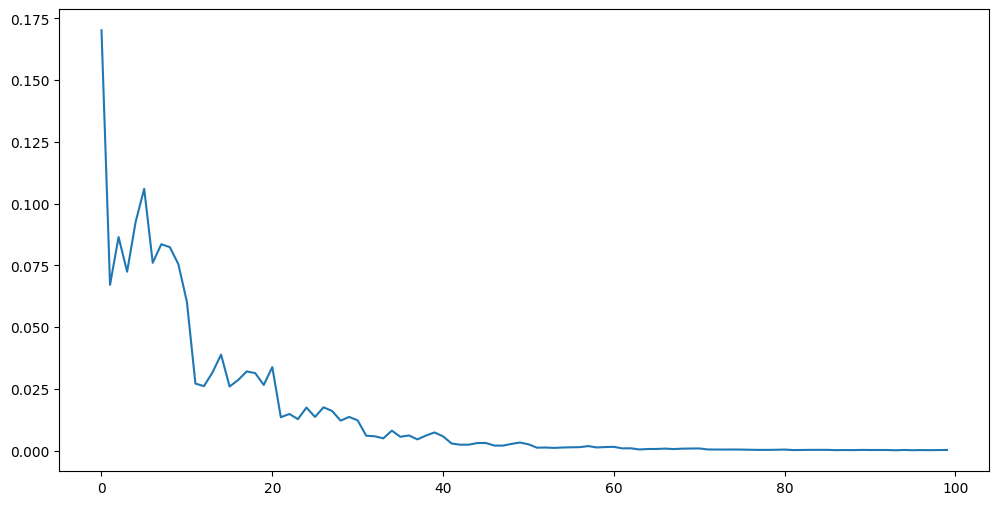

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(losses)), losses)

In [44]:
# def predict(state):
#     state = np.expand_dims(state, axis=0)  # Add batch dimension
#     state = tf.convert_to_tensor(state, dtype=tf.float32)
#     q_values = q_network(state)
#     action = np.argmax(q_values.numpy())  # Choose action with the highest Q-value
#     return action

In [45]:
# torch.save(q_network.state_dict(), "dqn_model.pth")

## inferring values

In [35]:
device = 'cpu'

In [51]:
def infer(q_network, state, state_size):
    """Infer Q-values and recommend an action for a given state."""
    state_tensor = torch.nn.functional.one_hot(torch.tensor([state]), num_classes=state_size).float()
    with torch.no_grad():
        q_values = q_network(state_tensor).numpy().flatten()
    best_action = q_values.argmax()
    return q_values, best_action

In [59]:
infer(q_network, data[130], state_size)

(array([0.5014375 , 0.63616925, 0.5523001 , 0.4988612 , 0.5033259 ,
        0.63715696, 0.55124384, 0.5038485 , 0.6026423 , 0.7326751 ,
        0.62815875, 0.63559306, 0.6026423 , 0.7326751 , 0.62815875,
        0.63559306, 0.6026423 , 0.7326751 , 0.62815875, 0.63559306],
       dtype=float32),
 9)

## Loading q_network

In [60]:
# Load model directly to GPU if available
q_network2 = QNetwork(state_size, action_size).to(device)
q_network2.load_state_dict(torch.load("dqn_model.pth"))
q_network2.eval()

/tmp/ipykernel_6329/3741015920.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_network2.load_state_dict(torch.load("dqn_model.pth"))


QNetwork(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [61]:
infer(q_network2, data[130], state_size)

(array([0.5014375 , 0.63616925, 0.5523001 , 0.4988612 , 0.5033259 ,
        0.63715696, 0.55124384, 0.5038485 , 0.6026423 , 0.7326751 ,
        0.62815875, 0.63559306, 0.6026423 , 0.7326751 , 0.62815875,
        0.63559306, 0.6026423 , 0.7326751 , 0.62815875, 0.63559306],
       dtype=float32),
 9)